<a href="https://colab.research.google.com/github/IZ001/Stat-Machine-Learning/blob/main/Code_for_the_report_of_Project_SML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task2 

Look into the provided data set by e.g. plotting the individual features. Based on your analysis,
answer the following questions:

• Do men or women dominate speaking roles in Hollywood movies?
• Has gender balance in speaking roles changed over time (i.e. years)?
• Do flms in which men do more speaking make a lot more money than flms in which women
speak more?
Write 1-2 sentences for each question and support your fndings with evidence (statistics, plots, ...).
Based on your analysis, you should evaluate how the worst-case classifer for this problem is expected
to perform. That is, the classifer that always randomly picks a class or always predicts the same
output class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.preprocessing as skl_pre

from google.colab import files
uploaded = files.upload()

import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']), na_values = '?').dropna().reset_index(drop=True)
# Dataset is now stored in a Pandas Dataframe

#import seaborn as sns

Saving train.csv to train.csv


In [2]:
data['Lead'] = np.where(data['Lead'] == 'Female', 1, 0)

In [3]:
# Split the data randomly into a training set and a test set of approximately similar size.

np.random.seed(1)
trainI = np.random.choice(data.shape[0], size= 700, replace=False)
trainIndex = data.index.isin(trainI)

train = data.iloc[trainIndex]
test = data.iloc[~trainIndex]

In [4]:
# Try different feature sets (with data scaling)

import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

min_error = data.shape[0]
error_a = 0
features_max = []
coef =0
conf_matrix =0
chosen_model =0
prob = 0

pc_auc = 0
roc_auc = 0
f1 = 0
roc_auc_a = 0
pc_auc_a = 0
pc_auc_max = 0
roc_auc_max = 0
f1_a = 0

s = {'Number words female', 'Total words', 'Number of words lead', 'Difference in words lead and co-lead', 'Number of male actors', 'Year', 'Number of female actors', 'Number words male', 'Gross', 'Mean Age Male', 'Mean Age Female','Age Lead', 'Age Co-Lead'}
n = 13

# define model
model = skl_lm.LogisticRegression(solver ='liblinear')

subsets = findsubsets(s, n)
for s in subsets:
  input_variables = list(s)

  x_train = train[input_variables]
  y_train = train['Lead']
  x_test = test[input_variables]
  y_test = test['Lead']

  scaler = skl_pre.StandardScaler().fit(x_train)
  model.fit(scaler.transform(x_train), y_train )
  predict_prob = model.predict_proba(scaler.transform(x_test))
  prediction = np.where(predict_prob[:,1] > 0.5, 1, 0)
  
  #Misclassification error
  error = np.mean(prediction != y_test)

  # calculate roc auc
  roc_auc = roc_auc_score(y_test, predict_prob[:,1])

  # calculate the precision-recall auc
  precision, recall, _ = precision_recall_curve(y_test, predict_prob[:,1])
  pc_auc = auc(recall, precision)
  f1 = f1 = 2*precision*recall/(precision+recall)

  # chose the model with the max ROC AUC
  if roc_auc > roc_auc_max:
    roc_auc_max = roc_auc
    error_a = error
    features_max = input_variables
    chosen_model = model
    conf_matrix = pd.crosstab(prediction, y_test)
    prob = predict_prob
    pc_auc_a = pc_auc
    f1_a = f1

#print(f1_a)
print(features_max)
print('Misclassification error',error_a)
print(f'ROC AUC = {roc_auc_max}')
print('PC AUC =', pc_auc_a)
print('F1 =', np.max(f1_a))
print(chosen_model.coef_)
print(chosen_model.classes_)
print(conf_matrix)




['Gross', 'Number of male actors', 'Mean Age Male', 'Year', 'Number words male', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Total words', 'Mean Age Female', 'Number words female', 'Age Lead']
Misclassification error 0.1415929203539823
ROC AUC = 0.879980079681275
PC AUC = 0.7768441684891018
F1 = 0.7012987012987013
[[-0.05366148 -1.31008883  0.2165877  -0.00853541  0.65896931  1.565523
   1.02174695  0.57172322 -1.60649287  0.24791482  0.04697703 -1.61633581
  -0.76838017]]
[0 1]
Lead     0   1
row_0         
0      240  37
1       11  51


In [5]:
X = data
y = data['Lead']

In [6]:
import sklearn.model_selection as skl_ms
import sklearn.preprocessing as skl_pre
n_runs = 20
features_lsts_with_big_roc_auc =[]
s = {'Number words female', 'Total words', 'Number of words lead', 'Difference in words lead and co-lead', 'Number of male actors', 'Year', 'Number of female actors', 'Number words male', 'Gross', 'Mean Age Male', 'Mean Age Female','Age Lead', 'Age Co-Lead'}

#s - set with all variables, n -number of variables in subsets
subsets_1 = findsubsets(s, 8)
subsets_2 = findsubsets(s, 9)
subsets_3 = findsubsets(s, 10)

subsets = subsets_1 + subsets_2 + subsets_3
roc_auc_n = np.zeros((n_runs, len(subsets)))
pc_auc = 0
error = 0
pc_auc = 0
f1 = 0

for i in range(n_runs):
  X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size = 0.3)
  
  for j, s in enumerate(subsets):
    input_variables = list(s)
      
    x_train = X_train[input_variables]
    x_test = X_val[input_variables]
    y_test = y_val

    model = skl_lm.LogisticRegression(solver ='liblinear')
    scaler = skl_pre.StandardScaler().fit(x_train)

    model.fit(scaler.transform(x_train), y_train)
    predict_prob = model.predict_proba(scaler.transform(x_test))
    prediction = np.where(predict_prob[:,1] > 0.5, 1, 0)

    # calculate roc auc
    roc_auc = roc_auc_score(y_test, predict_prob[:,1])
    roc_auc_n[i,j] = roc_auc

roc_auc_avg = np.mean(roc_auc_n, axis = 0)

for idx ,el in enumerate(roc_auc_avg):
  if el > np.max(roc_auc_avg)*(1-0.001):
    features_lsts_with_big_roc_auc.append(list(subsets[idx]))

for el in features_lsts_with_big_roc_auc:
  print(el)
  print('Number of features',len(el))


['Number of male actors', 'Mean Age Male', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Number words female', 'Age Lead']
Number of features 8
['Number of male actors', 'Number words male', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Number words female', 'Age Lead']
Number of features 8
['Number of male actors', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Total words', 'Number words female', 'Age Lead']
Number of features 8
['Number of male actors', 'Mean Age Male', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Total words', 'Number words female', 'Age Lead']
Number of features 9
['Number of male actors', 'Number words male', 'Number of female actors', 'Number of words lead', 'Age Co-Lead', 'Difference in words lead and co-lead', 'Total wor

In [7]:
# find the decision threshold 
def find_r(prob, y_test):
  recall = []
  precision = []
  f1_max = 0
  r_f1 = 0

  positive_class = 1
  negative_class = 0

  P = np.sum(y_test == positive_class)
  prediction = np.empty(len(x_test), dtype ='object')
  tr_val = np.linspace(0.00 , 1, num =101)

  for r in tr_val:
    prediction = np.where(prob[:,1] > r, positive_class, negative_class)
    P_star = np.sum(prediction == positive_class)
    tr_pos = np.sum((prediction == y_test)&(prediction == positive_class))

    rec = tr_pos/P
    prec = tr_pos/P_star
    
    f1 = 2*prec*rec/(prec+rec)
    if f1_max < f1:
      f1_max =f1
      r_f1 = r
    
  return r_f1

# cross-validation of r
#import sklearn.model_selection as skl_ms

def calculate_average_r(features, X, y):
# features -list of features
# X - data with all features
# y - column 'Lead'
  n_runs = 10

  tr_rates_n = np.zeros((n_runs))
  for i in range(n_runs):

    X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size = 0.3)
    model = skl_lm.LogisticRegression(solver ='liblinear')
    scaler = skl_pre.StandardScaler().fit(X_train[features])
    model.fit(scaler.transform(X_train[features]), y_train)
    predict_prob = model.predict_proba(scaler.transform(X_val[features]))
    
    tr_rates_n[i] = find_r(predict_prob, y_val)

  return np.average(tr_rates_n)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

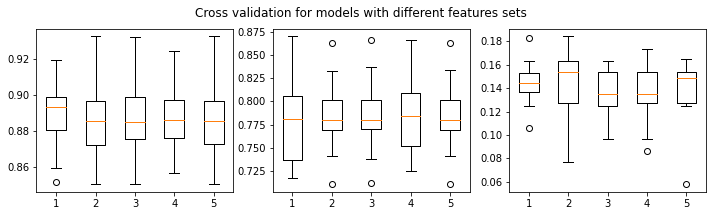

In [8]:
# cross-validation of models with k-fold 

#import sklearn.model_selection as skl_ms
features_list = features_lsts_with_big_roc_auc

n_runs = 10

pc_auc_n =np.zeros((n_runs, len(features_list)))
roc_auc_n = np.zeros((n_runs, len(features_list)))
misclassification_n = np.zeros((n_runs, len(features_list)))
tr_rate_models = []

X = data.drop(columns = 'Lead')
y = data['Lead']

n_fold = 10
cv = skl_ms.KFold(n_splits = n_fold, random_state = 1, shuffle = True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  for j,features in enumerate(features_list):
    model = skl_lm.LogisticRegression(solver ='liblinear')
    scaler = skl_pre.StandardScaler().fit(X_train[features])
    model.fit(scaler.transform(X_train[features]), y_train)
    predict_prob = model.predict_proba(scaler.transform(X_val[features]))

    # calculate the metrics
    precision, recall, _ = precision_recall_curve(y_val, predict_prob[:,1])
    pc_auc_n[i,j] = auc(recall, precision)
    roc_auc_n[i,j] = roc_auc_score(y_val, predict_prob[:,1])  

    tr_rate = calculate_average_r(features, X, y)
    prediction = np.where(predict_prob[:,1] > tr_rate, 1, 0)
    misclassification_n[i,j] = (np.mean(prediction != y_val))
    tr_rate_models.append(tr_rate)   # make table to count average

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)
axs[0].boxplot(roc_auc_n)
axs[1].boxplot(pc_auc_n)
axs[2].boxplot(misclassification_n)

fig.suptitle('Cross validation for models with different features sets')
plt.show()


In [9]:
# Model validation: find regularization type and rate
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

def validate_model(X,y):
  model = LogisticRegression()
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  space = dict()
  space['solver'] = ['liblinear']
  space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
  space['C'] = loguniform(1e-5, 100)

  search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
  res = search.fit(X, y)

  print('Score: %s' % res.best_score_)
  print('Hyperparameters: %s' % res.best_params_)
  return res.best_params_

# insert input variables (list of features) to validate the model
features = ['Total words', 'Age Co-Lead', 'Number of female actors', 'Difference in words lead and co-lead', 'Number of words lead', 'Age Lead', 'Number words female', 'Number of male actors']
validate_model(X[features], y)

Score: 0.8824215081683437
Hyperparameters: {'C': 11.255272403301097, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7590 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none

{'C': 11.255272403301097, 'penalty': 'l1', 'solver': 'liblinear'}

In [10]:
# Find threshold rate for the best model (result = 0.435)
features = ['Total words', 'Age Co-Lead', 'Number of female actors', 'Difference in words lead and co-lead', 'Number of words lead', 'Age Lead', 'Number words female', 'Number of male actors']
# parameters {'C': 18.31792545756584, 'penalty': 'l1', 'solver': 'liblinear'}

n_runs = 10
tr_rates_n = np.zeros((n_runs))
X = data[features]
y = data['Lead']

for i in range(n_runs):

  X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size = 0.3)

  model = skl_lm.LogisticRegression(solver ='liblinear', C = 18.31792545756584, penalty ='l1')
  scaler = skl_pre.StandardScaler().fit(X_train)
  model.fit(scaler.transform(X_train), y_train)
  predict_prob = model.predict_proba(scaler.transform(X_val))
  tr_rates_n[i] = find_r(predict_prob, y_val)

r_res = np.average(tr_rates_n)
print(r_res)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


0.42600000000000005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


ROC AUC 0.8876033271155791
PC AUC 0.7929100050122352
Error 0.13285100821508586


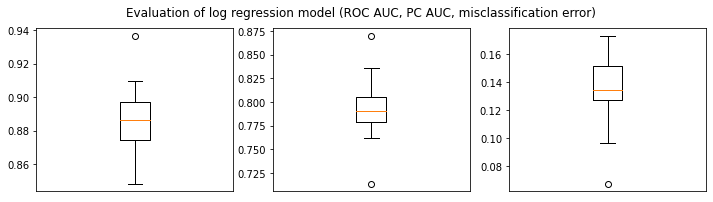

In [11]:
# Evaluate performance of logistic regression model
pc_auc_n2 =np.zeros((n_runs))
roc_auc_n2 = np.zeros((n_runs))
misclassification_n2 = np.zeros((n_runs))


n_fold = 10
cv = skl_ms.KFold(n_splits = n_fold, random_state = 1, shuffle = True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  model = skl_lm.LogisticRegression(solver ='liblinear', C = 18.31792545756584, penalty ='l1')

  scaler = skl_pre.StandardScaler().fit(X_train)
  model.fit(scaler.transform(X_train[features]), y_train)
  predict_prob = model.predict_proba(scaler.transform(X_val))
  # calculate the metrics
  precision, recall, _ = precision_recall_curve(y_val, predict_prob[:,1])

  pc_auc_n2[i] = auc(recall, precision)
  roc_auc_n2[i] = roc_auc_score(y_val, predict_prob[:,1])  


  tr_rate = 0.435
  prediction = np.where(predict_prob[:,1] > tr_rate, 1, 0)
  misclassification_n2[i] = (np.mean(prediction != y_val))

print('ROC AUC', np.average(roc_auc_n2))
print('PC AUC', np.average(pc_auc_n2))
print('Error', np.average(misclassification_n2))

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)
axs[0].boxplot(roc_auc_n2)
axs[1].boxplot(pc_auc_n2)
axs[2].boxplot(misclassification_n2)

axs[0].set_xticks(range(1))
axs[1].set_xticks(range(1))
axs[2].set_xticks(range(1))
#axs[0].set_xticklabels([str('ROC AUC')+"foo" for x in range(1)])
#axes.set_xticklabels(labels, fontdict=None, minor=False)

fig.suptitle('Evaluation of log regression model (ROC AUC, PC AUC, misclassification error)')
plt.show()
